In [1]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

!pip install torchviz

/kaggle/input/deep-learning-spring-2025-project-1/cifar_test_nolabel.pkl
/kaggle/input/deep-learning-spring-2025-project-1/cifar-10-python/cifar-10-batches-py/data_batch_1
/kaggle/input/deep-learning-spring-2025-project-1/cifar-10-python/cifar-10-batches-py/data_batch_2
/kaggle/input/deep-learning-spring-2025-project-1/cifar-10-python/cifar-10-batches-py/batches.meta
/kaggle/input/deep-learning-spring-2025-project-1/cifar-10-python/cifar-10-batches-py/test_batch
/kaggle/input/deep-learning-spring-2025-project-1/cifar-10-python/cifar-10-batches-py/data_batch_3
/kaggle/input/deep-learning-spring-2025-project-1/cifar-10-python/cifar-10-batches-py/data_batch_5
/kaggle/input/deep-learning-spring-2025-project-1/cifar-10-python/cifar-10-batches-py/data_batch_4
/kaggle/input/deep-learning-spring-2025-project-1/cifar-10-python/cifar-10-batches-py/readme.html


In [2]:
import os
import pickle
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
import pandas as pd
from PIL import Image
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.optim.lr_scheduler import StepLR
import torch.optim.lr_scheduler as lr_scheduler

In [3]:
class BottleneckBlock(nn.Module):
    """
    A bottleneck block for ResNet.
    In the original ResNet-50/101/152, the expansion is 4.
    So if out_channels=64, the final output is 64 * 4 = 256 channels.

    Args:
        in_channels (int): Number of input channels.
        out_channels (int): Number of "inner" channels before expansion.
        stride (int): Stride to apply in the 3x3 convolution.
    """
    expansion = 4  # Typical expansion factor

    def __init__(self, in_channels, out_channels, stride=1):
        super(BottleneckBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(
            out_channels, 
            out_channels, 
            kernel_size=3, 
            stride=stride, 
            padding=1, 
            bias=False
        )
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(
            out_channels, 
            out_channels * self.expansion, 
            kernel_size=1, 
            bias=False
        )
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        if stride != 1 or in_channels != out_channels * self.expansion:
            self.shortcut = nn.Sequential(
                nn.Conv2d(
                    in_channels, 
                    out_channels * self.expansion,
                    kernel_size=1, 
                    stride=stride, 
                    bias=False
                ),
                nn.BatchNorm2d(out_channels * self.expansion)
            )
        else:
            self.shortcut = nn.Identity()

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv3(out)
        out = self.bn3(out)
        out += self.shortcut(identity)
        out = self.relu(out)
        return out

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

class CustomResNetBottleneck(nn.Module):
    """
    A ResNet-like architecture using BottleneckBlocks.
    Adjust 'blocks_per_stage' and 'base_channels' to keep parameters < 5M.
    """
    def __init__(self, blocks_per_stage=[3, 4, 6, 3], base_channels=32, num_classes=10):
        """
        Args:
            blocks_per_stage (list): Number of BottleneckBlocks in each of the 4 stages.
            base_channels (int): The number of "inner" channels in the first bottleneck
                                 stage. (Note that output of the first stage will be 
                                 base_channels*4 if using Bottleneck.)
            num_classes (int): Number of output classes for classification.
        """
        super(CustomResNetBottleneck, self).__init__()

        self.in_channels = base_channels * BottleneckBlock.expansion
        self.conv1 = nn.Conv2d(3, self.in_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU(inplace=True)

        self.layer1 = self._make_layer(base_channels, blocks_per_stage[0], stride=1)
        self.layer2 = self._make_layer(base_channels * 2, blocks_per_stage[1], stride=2)
        self.layer3 = self._make_layer(base_channels * 4, blocks_per_stage[2], stride=2)
        self.layer4 = self._make_layer(base_channels * 8, blocks_per_stage[3], stride=2)

        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(base_channels * 8 * BottleneckBlock.expansion, num_classes)

    def _make_layer(self, out_channels, num_blocks, stride):
        """
        Creates a stage of bottleneck blocks.
        
        - First block may downsample if stride=2
        - out_channels is the "inner" dimension; actual block out is out_channels * expansion
        """
        layers = []
        layers.append(BottleneckBlock(self.in_channels, out_channels, stride=stride))
        self.in_channels = out_channels * BottleneckBlock.expansion

        for _ in range(1, num_blocks):
            layers.append(BottleneckBlock(self.in_channels, out_channels, stride=1))

        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avg_pool(out)
        out = torch.flatten(out, 1)
        out = self.fc(out)
        return out


In [4]:
def get_data(batch_size=128):
    transform_train = transforms.Compose([
        transforms.AutoAugment(policy=transforms.AutoAugmentPolicy.CIFAR10),
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.RandomRotation(15),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
        
    train_dataset = torchvision.datasets.CIFAR10(root='/kaggle/input/deep-learning-spring-2025-project-1/cifar-10-python', train=True,
                                                 download=False, transform=transform_train)
    val_dataset = torchvision.datasets.CIFAR10(root='/kaggle/input/deep-learning-spring-2025-project-1/cifar-10-python', train=False,
                                                download=False, transform=transform_test)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    return train_loader, val_loader

In [6]:
import torch

def train_one_epoch(model, train_loader, criterion, optimizer, device):
    """
    Returns both average training loss and training accuracy for the epoch.
    """
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

    avg_loss = running_loss / len(train_loader)
    accuracy = 100.0 * correct / total
    return avg_loss, accuracy

def evaluate(model, val_loader, criterion, device):
    """
    Returns both average validation/test loss and validation/test accuracy.
    """
    model.eval()
    correct = 0
    total = 0
    running_loss = 0.0

    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            running_loss += loss.item()

            _, predicted = torch.max(outputs, dim=1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

    avg_loss = running_loss / len(val_loader)
    accuracy = 100.0 * correct / total
    return avg_loss, accuracy

In [7]:
def print_model_summary(model):
    """
    Prints a layer-by-layer summary of the model (PyTorch's builtin print).
    For a more advanced summary, you could use torchinfo.summary().
    """
    print("Model Architecture:\n")
    print(model)
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"\nTotal trainable parameters: {total_params}")

    for name, param in model.named_parameters():
        if param.requires_grad:
            layer_names.append(name)
            param_counts.append(param.numel())

    sorted_indices = np.argsort(param_counts)[::-1]
    sorted_layer_names = [layer_names[i] for i in sorted_indices]
    sorted_param_counts = [param_counts[i] for i in sorted_indices]


In [8]:
    Args:
        model: Your PyTorch model.
        input_size (tuple): The shape of the input batch. 
            Default is (1, 3, 32, 32) for a single 3x32x32 image.
        device (str): 'cuda' or 'cpu'.

    Returns:
        A GraphViz object you can display in Jupyter.
    """
    model.eval()
    dummy_input = torch.randn(*input_size).to(device)
    output = model(dummy_input)

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Using: ',device)

train_loader, val_loader = get_data(batch_size=128)

model_bottleneck = CustomResNetBottleneck(blocks_per_stage=[7, 6, 6, 2], base_channels=32, num_classes=10).to(device)

print("Total parameters:", count_parameters(model_bottleneck))

Using:  cuda
Total parameters: 4995338


In [10]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
epochs = 180
batch_size = 128
lr = 0.01
momentum = 0.9
weight_decay = 5e-4
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_bottleneck.parameters(), lr=lr,
                      momentum=momentum,
                      weight_decay=weight_decay)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5, verbose=True)

best_acc = 0.0
for epoch in range(1, epochs + 1):
    t_loss, t_acc = train_one_epoch(model_bottleneck, train_loader, criterion, optimizer, device)
    v_loss, v_acc = evaluate(model_bottleneck, val_loader, criterion, device)

    train_losses.append(t_loss)
    train_accuracies.append(t_acc)
    val_losses.append(v_loss)
    val_accuracies.append(v_acc)
    
    scheduler.step(v_acc)

    if v_acc > best_acc:
        best_acc = v_acc
        torch.save(model_bottleneck.state_dict(), "best_bottleneck_cifar10.pth")

    print(f"Epoch [{epoch}/{epochs}] "f"Train Loss: {t_loss:.4f} | Train Acc: {t_acc:.2f}% | "f"Val Loss: {v_loss:.4f} | Val Acc: {v_acc:.2f}% | "f"Best: {best_acc:.2f}%")

print(f"Finished training. Best test acc = {best_acc:.2f}%")

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/180] Train Loss: 2.0818 | Train Acc: 22.84% | Val Loss: 1.6237 | Val Acc: 40.33% | Best: 40.33%
Epoch [2/180] Train Loss: 1.7590 | Train Acc: 35.52% | Val Loss: 1.4157 | Val Acc: 49.22% | Best: 49.22%
Epoch [3/180] Train Loss: 1.5157 | Train Acc: 45.42% | Val Loss: 1.2987 | Val Acc: 54.65% | Best: 54.65%
Epoch [4/180] Train Loss: 1.3372 | Train Acc: 52.32% | Val Loss: 1.3856 | Val Acc: 60.78% | Best: 60.78%
Epoch [5/180] Train Loss: 1.1958 | Train Acc: 57.61% | Val Loss: 0.8835 | Val Acc: 68.97% | Best: 68.97%
Epoch [6/180] Train Loss: 1.0850 | Train Acc: 61.84% | Val Loss: 0.8450 | Val Acc: 69.69% | Best: 69.69%
Epoch [7/180] Train Loss: 1.0059 | Train Acc: 64.86% | Val Loss: 0.7833 | Val Acc: 72.97% | Best: 72.97%
Epoch [8/180] Train Loss: 0.9429 | Train Acc: 66.96% | Val Loss: 0.7240 | Val Acc: 75.20% | Best: 75.20%
Epoch [9/180] Train Loss: 0.8924 | Train Acc: 68.86% | Val Loss: 0.7118 | Val Acc: 75.81% | Best: 75.81%
Epoch [10/180] Train Loss: 0.8563 | Train Acc: 70.16% |

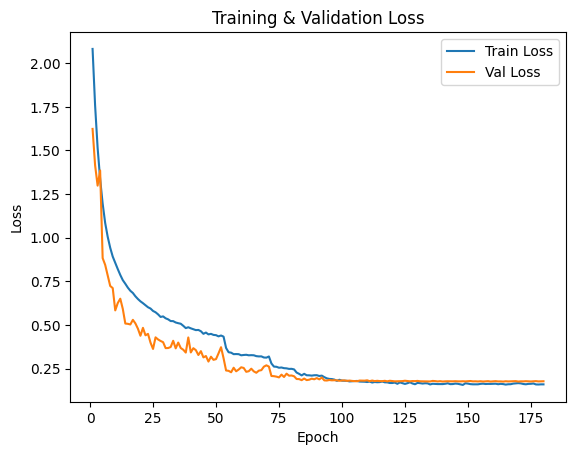

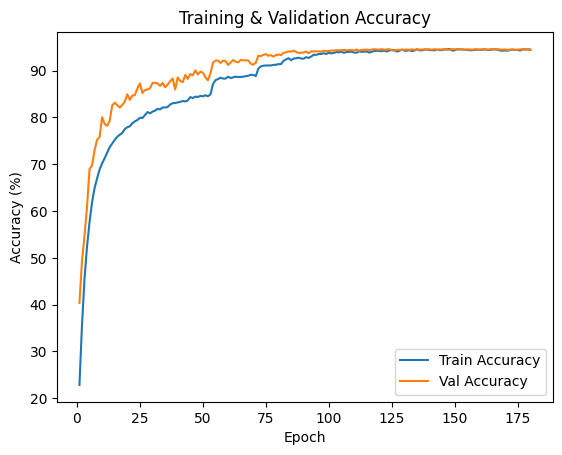

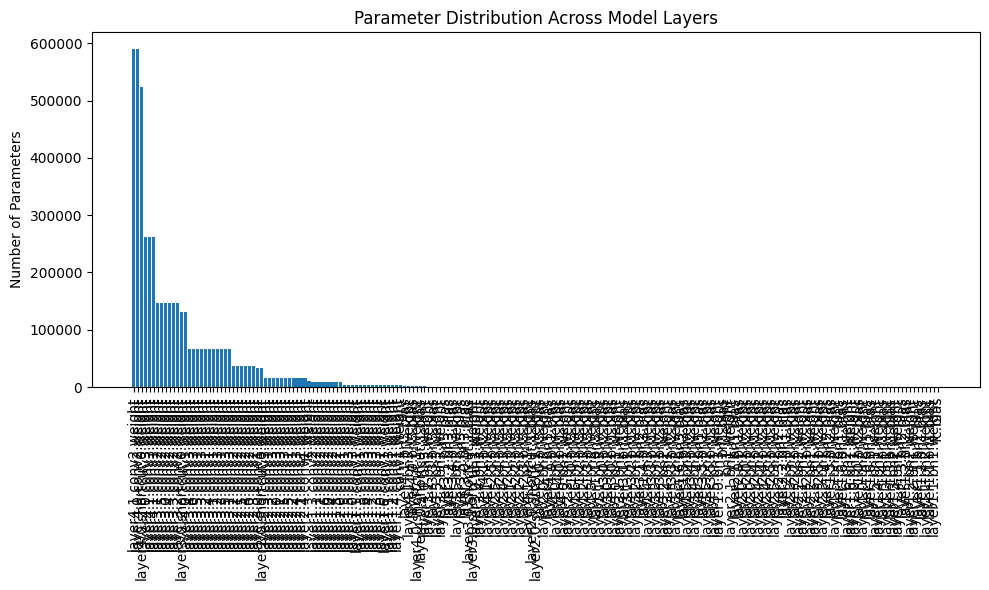

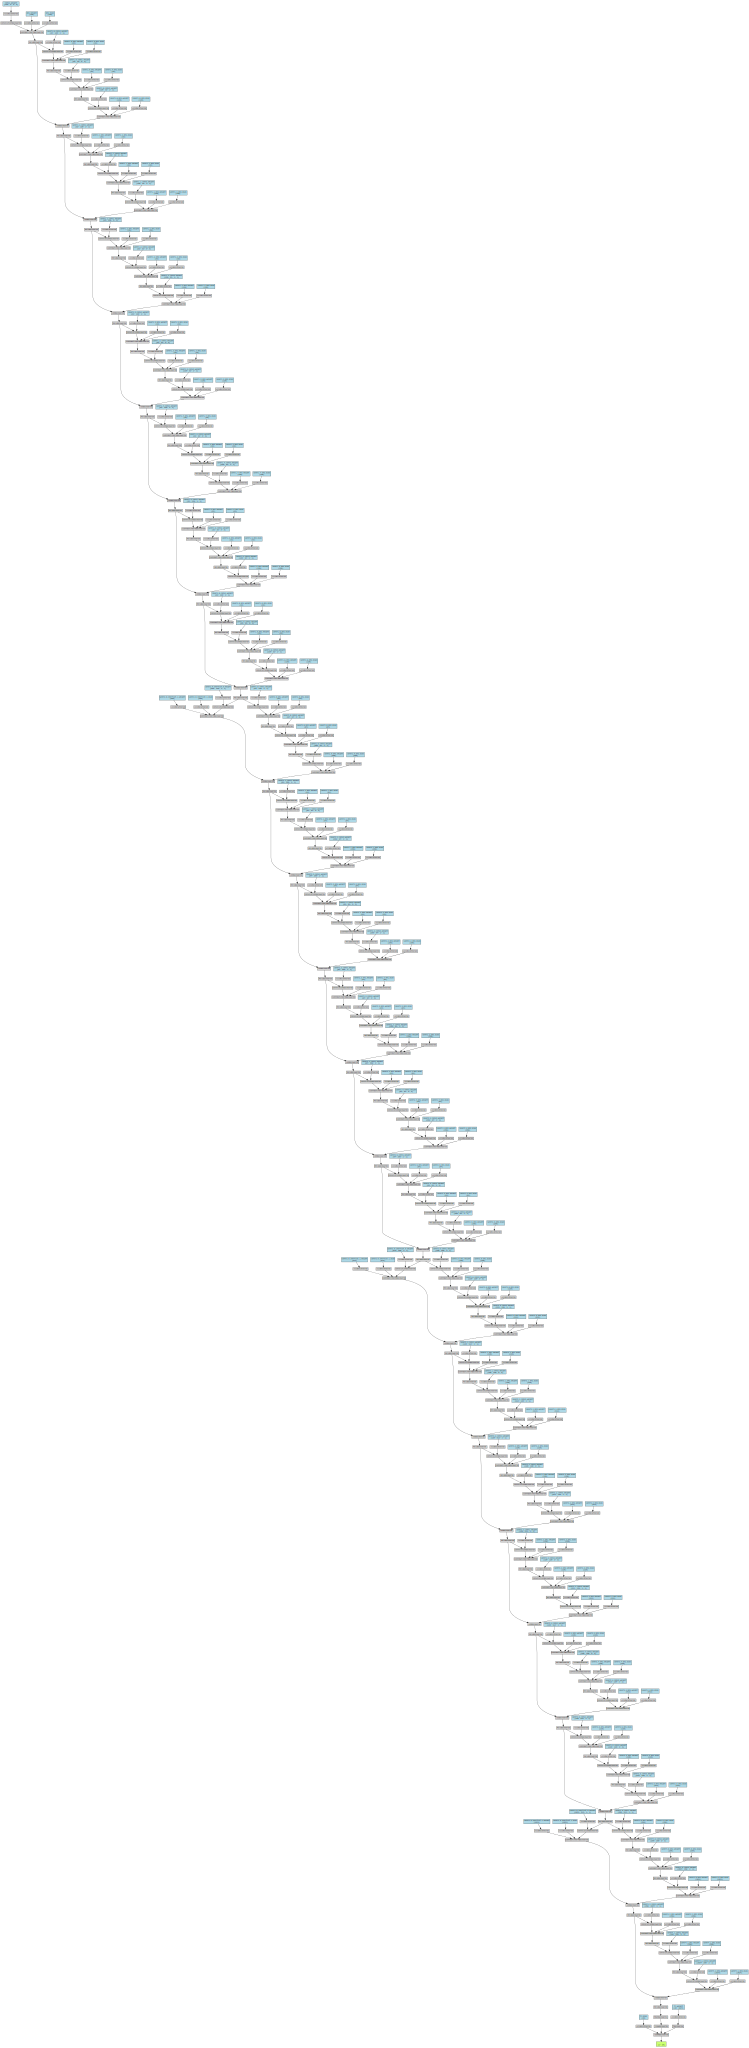

In [13]:
from IPython.display import display


In [14]:
def load_cifar_batch(file):
    with open(file, 'rb') as fo:
        batch = pickle.load(fo, encoding='bytes')
    return batch

cifar10_batch = load_cifar_batch('/kaggle/input/deep-learning-spring-2025-project-1/cifar_test_nolabel.pkl')

images = cifar10_batch[b'data']
print(f"Loaded test batch with {images.shape[0]} images")

Loaded test batch with 10000 images


In [15]:
class TestDatasetFromArray(Dataset):
    def __init__(self, images, transform=None):
        self.images = images
        if transform is None:
            self.transform = transforms.Compose([
                transforms.ToPILImage(),
                transforms.ToTensor(),
                transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
            ])
        else:
            self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        if isinstance(img, np.ndarray):
            img = img.astype('uint8')
        if self.transform:
            img = self.transform(img)
        return img

test_dataset = TestDatasetFromArray(images)
loader_test = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [ ]:

if os.path.exists("best_bottleneck_cifar10.pth"):
    model_bottleneck.load_state_dict(torch.load("best_bottleneck_cifar10.pth", map_location=device))
    print("Loaded model checkpoint from best_bottleneck_cifar10.pth")
else:
    print("No checkpoint found. Running inference with untrained model.")

from datetime import datetime

n1 = datetime.now()
print(n1)

model_bottleneck.eval()
predictions = []
with torch.no_grad():
    for batch in loader_test:
        batch = batch.to(device)
        outputs = model_bottleneck(batch)
        _, preds = torch.max(outputs, 1)
        predictions.extend(preds.cpu().numpy().tolist())



filename = 'submission_bottleneck_'+str(n1)+'.csv' 
df = pd.DataFrame({"ID": range(len(predictions)), "Labels": predictions})
df.to_csv(filename, index=False)
print("Predictions saved to "+ filename)